### [Anomaly Detection for Dummies](https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1)

Dataset: [Superstore Sales](https://community.tableau.com/docs/DOC-1236)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

#### Load and understand data

In [3]:
df = pd.read_excel('./datasets/superstore.xls')

 - **Distribution of sales in the data**

In [4]:
df['Sales'].describe()

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64

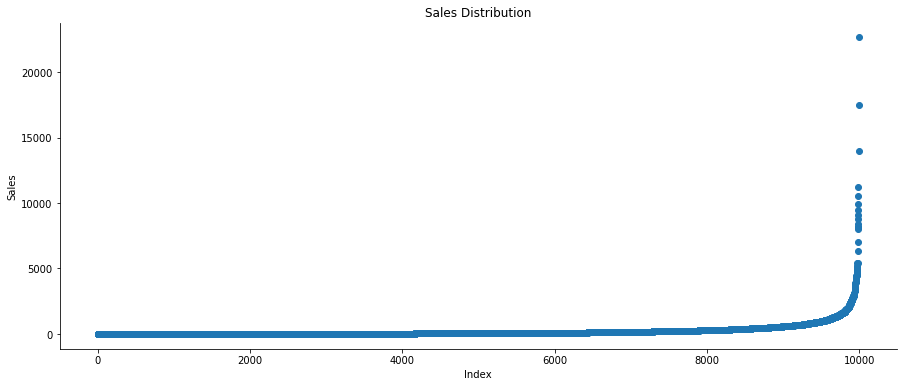

In [5]:
plt.figure(figsize=(15, 6))
plt.scatter(range(df.shape[0]), np.sort(df['Sales'].values))
plt.xlabel('Index')
plt.ylabel('Sales')
plt.title('Sales Distribution')
sns.despine()

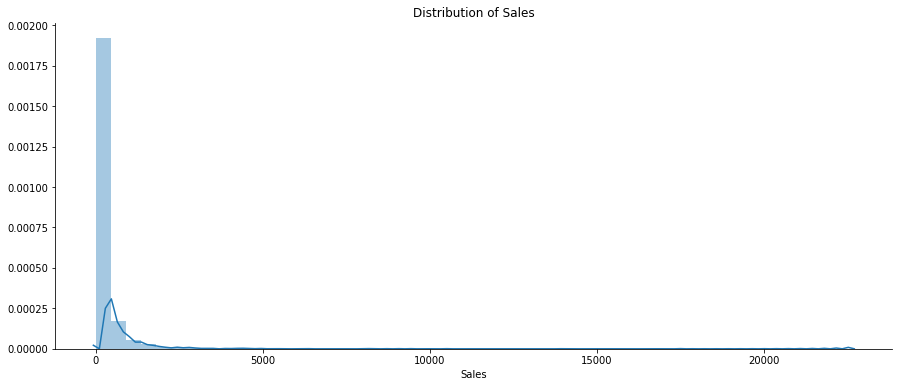

In [6]:
plt.figure(figsize=(15, 6))
sns.distplot(df['Sales'])
plt.title('Distribution of Sales')
sns.despine()

In [7]:
print('Skewness: {}'.format(df['Sales'].skew()))
print('Kurtosis: {}'.format(df['Sales'].kurt()))

Skewness: 12.972752341816228
Kurtosis: 305.31175324682283


 - **Distribution of Profit**

In [8]:
df['Profit'].describe()

count    9994.000000
mean       28.656896
std       234.260108
min     -6599.978000
25%         1.728750
50%         8.666500
75%        29.364000
max      8399.976000
Name: Profit, dtype: float64

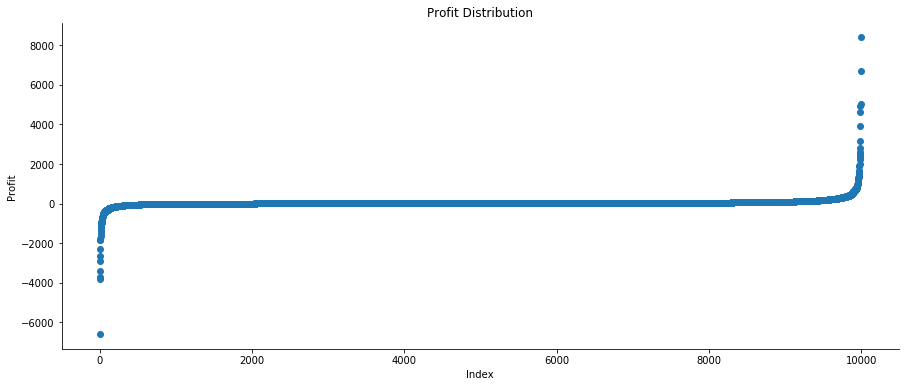

In [9]:
plt.figure(figsize=(15, 6))
plt.scatter(range(df.shape[0]), np.sort(df['Profit'].values))
plt.xlabel('Index')
plt.ylabel('Profit')
plt.title('Profit Distribution')
sns.despine()

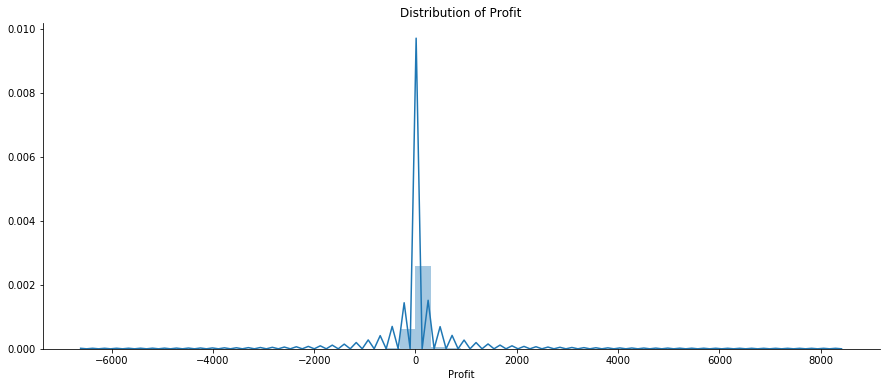

In [10]:
plt.figure(figsize=(15, 6))
sns.distplot(df['Profit'])
plt.title('Distribution of Profit')
sns.despine()

In [11]:
print('Skewness: {}'.format(df['Profit'].skew()))
print('Kurtosis: {}'.format(df['Profit'].kurt()))

Skewness: 7.561431562468336
Kurtosis: 397.188514552414


#### Univariate anamoly detection on Sales

Train [IsolationForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) using the Sales data.

In [12]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['Sales'].values.reshape(-1, 1))

IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

Store the Sales in `NumPy` array.

In [13]:
xx = np.linspace(df['Sales'].min(), df['Sales'].max(), len(df)).reshape(-1, 1)

Compute anamoly score.

In [14]:
anomaly_score = isolation_forest.decision_function(xx)

Classify outliers.

In [15]:
outlier = isolation_forest.predict(xx)

C:\Users\harshil\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Visualization to identify regions where outliers fall.

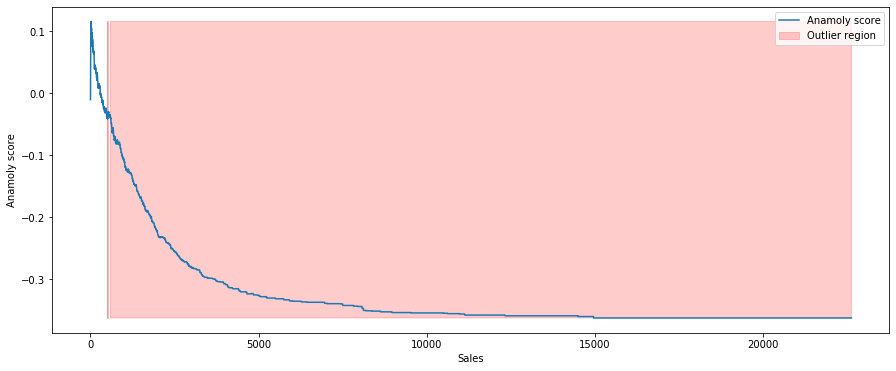

In [16]:
plt.figure(figsize=(15, 6))

plt.plot(xx, anomaly_score, label='Anamoly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), where=outlier==-1, color='r', alpha=.2, label='Outlier region')
plt.legend()

plt.ylabel('Anamoly score')
plt.xlabel('Sales');

According to this visualization, Sales that exceeds 1000 would definitely be considered as an outlier.

#### Univariate anamoly detection on Profit

Train [IsolationForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) using the Profit data.

In [17]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['Profit'].values.reshape(-1, 1))

IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

Store the Profit in `NumPy` array.

In [18]:
xx = np.linspace(df['Profit'].min(), df['Profit'].max(), len(df)).reshape(-1, 1)

Compute anamoly score.

In [19]:
anomaly_score = isolation_forest.decision_function(xx)

Classify outliers.

In [20]:
outlier = isolation_forest.predict(xx)

C:\Users\harshil\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Visualization to identify regions where outliers fall.

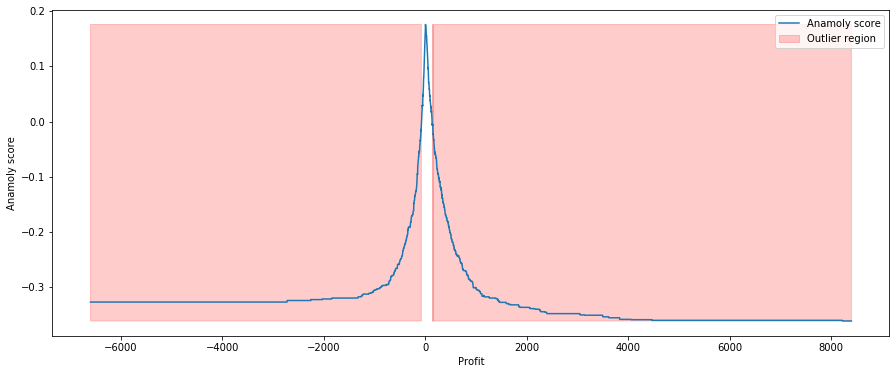

In [21]:
plt.figure(figsize=(15, 6))

plt.plot(xx, anomaly_score, label='Anamoly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), where=outlier==-1, color='r', alpha=.2, label='Outlier region')
plt.legend()

plt.ylabel('Anamoly score')
plt.xlabel('Profit');

#### Multivariate anomaly detection

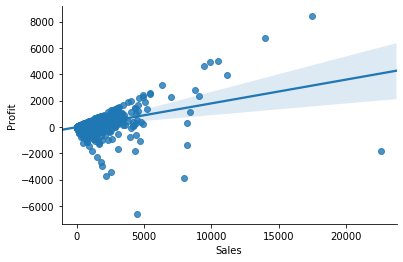

In [22]:
sns.regplot(x='Sales', y='Profit', data=df)
sns.despine();

**Prepare data.**

In [23]:
cols = ['Sales', 'Profit']
df[cols].head()

,Sales,Profit
0,261.9600,41.9136
1,731.9400,219.5820
2,14.6200,6.8714
3,957.5775,-383.0310
4,22.3680,2.5164


In [24]:
minmax = MinMaxScaler(feature_range=(0, 1))
df[cols] = minmax.fit_transform(df[cols])
df[cols].head()

,Sales,Profit
0,0.011552,0.442794
1,0.032313,0.454639
2,0.000626,0.440458
3,0.042280,0.414464
4,0.000968,0.440168


In [25]:
x1 = df['Sales'].values.reshape(-1, 1)
x2 = df['Profit'].values.reshape(-1, 1)

In [26]:
X = np.concatenate((x1, x2), axis=1)

In [27]:
outliers_fraction = 0.01

In [28]:
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

**A function to identify and plot outliers.**

In [29]:
def outlier_detection(clf):
    clf.fit(X)
    
    scores_pred = clf.decision_function(X) * -1
    y_pred = clf.predict(X)
    
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred==1)
    
    plt.figure(figsize=(8, 8))
    
    df1 = df
    df1['outlier'] = y_pred.tolist()
    
    # Sales: feature 1, Profit: feature 2
    inlier_sales = np.array(df1['Sales'][df1['outlier']==0].values.reshape(-1, 1))
    inlier_profit = np.array(df1['Profit'][df1['outlier']==0].values.reshape(-1, 1))
    
    outlier_sales = df1['Sales'][df1['outlier']==1].values.reshape(-1, 1)
    outlier_profit = df1['Profit'][df1['outlier']==1].values.reshape(-1, 1)
    
    print('Outliers: {}, Inliers: {}'.format(n_outliers, n_inliers))
    
    threshold = stats.scoreatpercentile(scores_pred, 100*outliers_fraction)
    
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r)
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='orange')
    b = plt.scatter(inlier_sales, inlier_profit, c='white', s=20, edgecolor='k')

    c = plt.scatter(outlier_sales, outlier_profit, c='black', s=20, edgecolor='k')

    plt.axis('tight')   
    plt.legend([a.collections[0], b, c],
               ['learned decision function', 'inliers','outliers'],
               prop=matplotlib.font_manager.FontProperties(size=20),
               loc='lower right')      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title('Cluster-based Local Outlier Factor (CBLOF)');

**Cluster Based Local Outlier Factor (CBLOF)**

In [30]:
clf = CBLOF(contamination=outliers_fraction, check_estimator=False, random_state=0)

Outliers: 100, Inliers: 9894


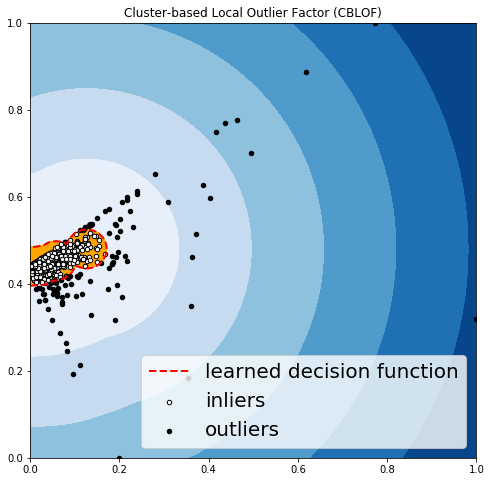

In [31]:
outlier_detection(clf)

**Histogram-based Outlier Detection (HBOS)**

In [32]:
clf = HBOS(contamination=outliers_fraction)

Outliers: 90, Inliers: 9904


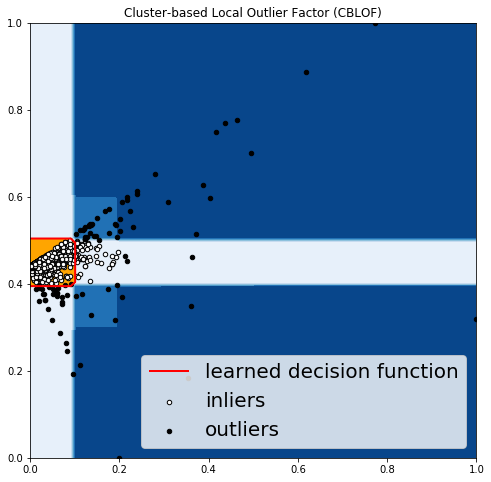

In [33]:
outlier_detection(clf)

**Isolation Forest**

In [34]:
clf = IForest(contamination=outliers_fraction, random_state=0)

Outliers: 100, Inliers: 9894


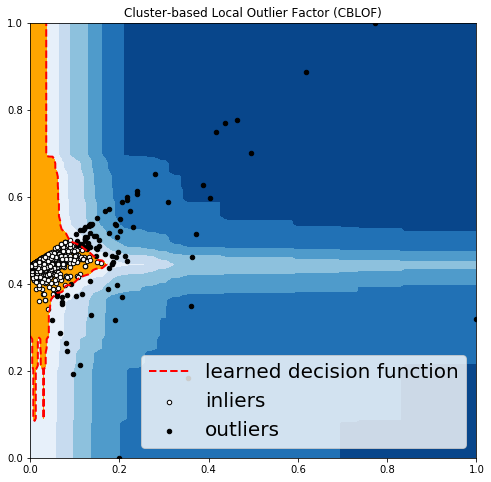

In [35]:
outlier_detection(clf)

**K - Nearest Neighbors (KNN)**

In [36]:
clf = KNN(contamination=outliers_fraction)

Outliers: 91, Inliers: 9903


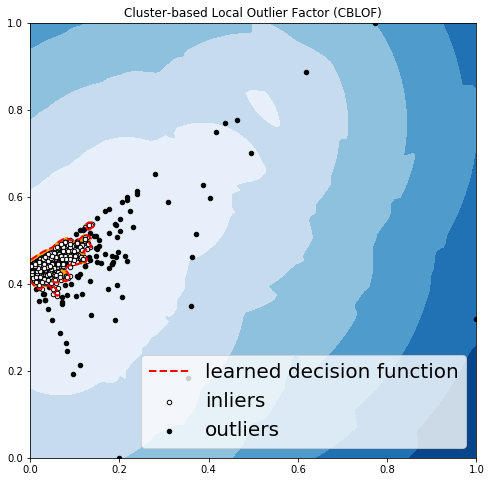

In [37]:
outlier_detection(clf)